# XPCS&XSVS for Dose-Dependnet SAXS|Gi-SAXS Analysis
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [50]:
from chxanalys.chx_packages import *
from chxanalys.chx_xpcs_xsvs_jupyter_V1 import *
%matplotlib notebook
# %matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
# %reset -f  #for clean up things in the memory

## Control Multi-Runs Parameters

In [51]:
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)

scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)


force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_one_time = True  #run  one-time
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time = False #True #True #False    #run  two-time
run_four_time = False   #run  four-time
run_xsvs= True #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
use_imgsum_norm=True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_1'     #for pdf report name
if scat_geometry == 'gi_saxs':run_xsvs= False 

In [52]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None;  

## Make a directory for saving results

In [53]:
CYCLE = '2017_1'
username = getpass.getuser()
username = 'jain'

#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)



Results from this analysis will be stashed in the directory /XF11ID/analysis/2017_1/jain/Results/


## Load Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [54]:
mask_path = '/XF11ID/analysis/2017_1/masks/'
mask_name = 'Apr5_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


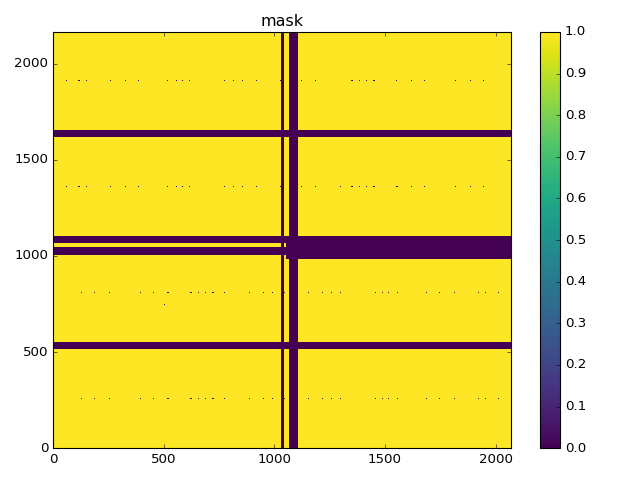

In [55]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = '%s_mask'%mask_name, reverse=True ) 
#mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'mask', save=True, path=data_dir)
mask_load=mask.copy()

## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

# Two ways to get uid
* give start and stop time
* give uids as a list

In [56]:
#first way 
#start_time, stop_time = '2017-4-5 13:45:00', '2017-4-5 14:38:00'
#sids, uids, fuids = find_uids(start_time, stop_time)
#print(uids)

#Second way 
uids = np.array(   [  'd8f42897', 'f2562978', 'eb4cd4c0' ,'e4c36f6c'  ] ) 

#'2a1196'] (scan num: 21620) (Measurement: 750Hz, Tr=1 5k fr PS220_AUPEG50 )
#'fd9f80'] (scan num: 21621) (Measurement: 400Hz, Tr=.5 5k fr PS220_AUPEG50 )
#'7d18ad'] (scan num: 21623) (Measurement: 100Hz, Tr=.1 5k fr PS220_AUPEG50 )                    
#'13e83a'] (scan num: 21624) (Measurement: 10Hz, Tr=.1 5k fr PS220_AUPEG50 )  

 
fuids = np.array(   [  db[uid]['start']['uid'] for uid in uids ]  )
uid = uids[0]
print( uids )

#uid = uids[2]
uidstr = 'uid=%s'%uid

['d8f42897' 'f2562978' 'eb4cd4c0' 'e4c36f6c']


In [57]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [58]:
#guids, buids = check_bad_uids( uids, mask, img_choice_N = 1, bad_uids_index=[1, 2] )

guids, buids = check_bad_uids( uids, mask, img_choice_N = 1, bad_uids_index=[ ] )
print( 'The good uids are: %s.\nThe good uids length is %s.'%(guids, len(guids)) )

The total and bad uids number are 4 and 0, repsectively.
The good uids are: ['d8f42897', 'f2562978', 'eb4cd4c0', 'e4c36f6c'].
The good uids length is 4.


In [59]:
gfuids = fuids[np.array( [ np.where( uids ==  s )[0][0] for s in guids  ] )]
print( gfuids)

['d8f42897-8151-4543-ac76-361c203cd24d'
 'f2562978-ac97-43c6-9a91-3918b4fbafb3'
 'eb4cd4c0-8c90-494c-a974-091b69e9cdb3'
 'e4c36f6c-c443-46d7-b264-7b06897de907']


# Don't Change these lines below here

In [60]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [61]:
md = get_meta_data( uid )

In [62]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )
imgsa = apply_mask( imgs, mask )

The data are: Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


In [63]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  'transmission',
         'det_distanc', 'beam_center_x', 'beam_center_y', ] )

suid--> d8f42897
number of images--> 500
uid--> d8f42897-8151-4543-ac76-361c203cd24d
scan_id--> 21632
start_time--> 2017-04-05 13:50:47
stop_time--> 2017-04-05 13:51:07
sample--> purePS220_vf026
Measurement--> 750Hz, Tr=. 500 fr purePS220_vf026
acquire period--> 0.00134
exposure time--> 0.1
transmission--> 1.0
beam_center_x--> 1091.0
beam_center_y--> 1022.0


## Overwrite Some Metadata Due to Wrong Input

In [64]:
inc_x0 = None
inc_y0=  None


dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )

setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

print_dict( setup_pargs )

lambda_--> 1.28401
timeperframe--> 0.00134
path--> /XF11ID/analysis/2017_1/jain/Results/
uid--> uid=d8f42897
Ldet--> 4908.744460000001
center--> [1022, 1091]
dpix--> 0.0750000035623
exposuretime--> 0.0013299999991431832


# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [65]:
img_choice_N = 1
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uid)
if avg_img.max() == 0:
    print('There are no photons recorded fdata_diror this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')

<IPython.core.display.Javascript object>


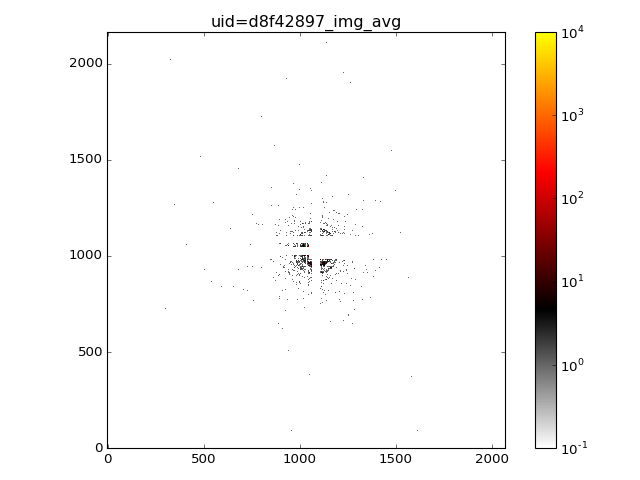

In [66]:
show_img( avg_img,  vmin=.1, vmax= 1e4, logs=True, aspect=1,
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

# SAXS Scattering Geometry

<IPython.core.display.Javascript object>


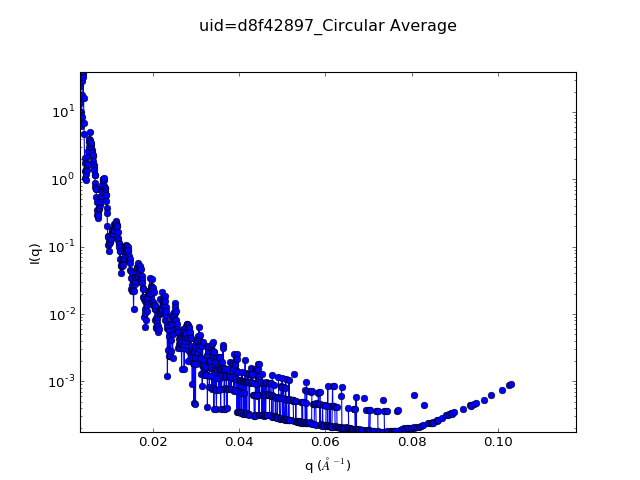

In [67]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, 
                      xlim=[q_saxs.min(), q_saxs.max()], ylim = [iq_saxs.min(), iq_saxs.max()] )

    mask =np.array( mask * hmask, dtype=bool) 
    #show_img( mask )

In [68]:
if scat_geometry =='saxs':
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  

In [69]:
if scat_geometry =='saxs':    
    uniformq =  True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:    
        width = 0.0002  # in A-1    
        #width = 0.0001
        number_rings= 1         
        qcenters = [
                    0.034,0.0534
                        ]
        edges = get_non_uniform_edges(  qcenters, width, number_rings )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:    
        inner_radius= 0.01
        outer_radius = 0.08   
        num_rings = 16  #72
        gap_ring_number = 50
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        print(width)
        edges = None

0.0010606060606060607


<IPython.core.display.Javascript object>


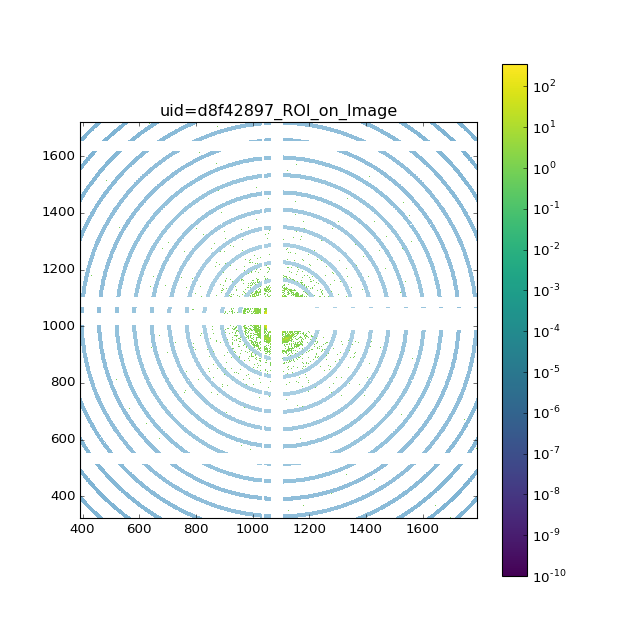

In [70]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 4)
    show_ROI_on_image( avg_img, roi_mask, center, label_on = False, rwidth =700, alpha=.9,  
                     save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 
    qval_dict = get_qval_dict( np.round(qr, 4)  ) 

<IPython.core.display.Javascript object>


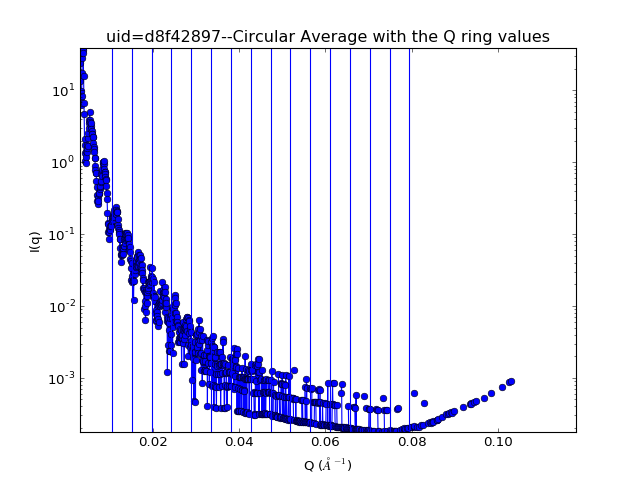

In [71]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, xlim=[q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()],  save=True, path=data_dir)

# GiSAXS Scattering Geometry

In [72]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users put incident-Beam and Reflection_Beam Centers here!!!
    # Change these lines
    inc_x0=setup_pargs['center'][0]
    inc_y0=setup_pargs['center'][1]
    if incidence_angle == 0.14:    

        refl_x0 = 1066
        refl_y0 = 692
    if incidence_angle == 0.24:

        refl_x0 = 1066
        refl_y0 = 915
    
    # Don't Change these lines below here
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

In [73]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

#     qz_start = 0.025
#     qz_end = 0.035
#     qz_num= 1
#     gap_qz_num = 1
#     qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qz_start = 0.031
    qz_end = 0.041
    qz_num= 1
    gap_qz_num = 1
    qz_width = (qz_end - qz_start)/(qz_num +gap_qz_num)
    
    qr_start =  0.005
    qr_end = 0.055
    qr_num = 9
    gap_qr_num = 1
    qr_width = ( qr_end- qr_start)/(qr_num+gap_qr_num)

    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )

In [74]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = False  #True #False  #if True to define another line; else: make it False    
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.04
        qz_end2 = 0.050
        qz_num2= 1
        gap_qz_num2 = 1
        qz_width2 = (qz_end2 - qz_start2)/(qz_num2 +gap_qz_num2)    
        qr_start2 =  0.002
        qr_end2 = 0.064
        qr_num2 = 10
        gap_qr_num2 = 5
        qr_width2 = ( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0,  setup_pargs=setup_pargs )
    qr_1d_pds_label = list( qr_1d_pds.columns )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=False, save=True, uid=uidstr, path = data_dir)

## Run_Does_Analysis

In [75]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter.py#

#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [76]:
guids

['d8f42897', 'f2562978', 'eb4cd4c0', 'e4c36f6c']

In [77]:
good_start = 5

### Compress data for the series of uids

In [78]:
compress_multi_uids( guids, mask, force_compress= False,  bin_frame_number=1 )

UID: d8f42897 is in processing...
Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_d8f42897-8151-4543-ac76-361c203cd24d.cmp.
Using a multiprocess to compress the data.
It will create 5 temporary files for parallel compression.
#####Bad frame list are: [0]
Combining the seperated compressed files together...
UID: f2562978 is in processing...
Sliced and/or processed EigerImages2. Original repr:
    <Frames>
    Length: 1994 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
Create a new compress file with filename as :/XF11ID/analysis/Compressed_Data/uid_f2562978-ac97-43c6-9a91-3918b4fbafb3.cmp.
Using a multiprocess to compress the data.
The average image intensity would be slightly not correct, about 1% error.
Please give a num_sub to make reminder of Num_images/num_sub =0 to get a correct avg_image


### Get two-time correlation functions for  the series of uids

In [79]:
if use_sqnorm:
    norm = get_pixelist_interp_iq( qp_saxs, iq_saxs, roi_mask, center)
else:
    norm=None

In [80]:
get_two_time_mulit_uids( guids, roi_mask,  norm= norm,  bin_frame_number=1, 
                        path= data_dir, force_generate=False )

UID: d8f42897 is in processing...


100%|██████████| 16/16 [00:05<00:00,  1.98it/s]


The two time correlation function for uid=d8f42897 is saved as /XF11ID/analysis/2017_1/jain/Results/d8f42897/uid=d8f42897_g12b.
UID: f2562978 is in processing...


100%|██████████| 16/16 [00:48<00:00,  4.03s/it]


The two time correlation function for uid=f2562978 is saved as /XF11ID/analysis/2017_1/jain/Results/f2562978/uid=f2562978_g12b.
UID: eb4cd4c0 is in processing...


100%|██████████| 16/16 [00:12<00:00,  1.06s/it]


The two time correlation function for uid=eb4cd4c0 is saved as /XF11ID/analysis/2017_1/jain/Results/eb4cd4c0/uid=eb4cd4c0_g12b.
UID: e4c36f6c is in processing...


100%|██████████| 16/16 [00:12<00:00,  1.03s/it]

The two time correlation function for uid=e4c36f6c is saved as /XF11ID/analysis/2017_1/jain/Results/e4c36f6c/uid=e4c36f6c_g12b.


### Calculate dose-dependent one-time correlation functions for the series of uids

##### Define dose to get dose-frame number

In [81]:
md['transmission']

1.0

In [82]:
N = len(imgs)
print(N)
exposure_dose = md['transmission'] * exposuretime* np.int_([   N/16, N/8, N/4 ,N/2, 3*N/4, N*.95 ] )
# exposure_dose = md['transmission'] * exposuretime* np.int_([   N/8, N/4 ,N/2, 3*N/4, N ] )
exposure_dose

500


array([ 0.04123,  0.08246,  0.16625,  0.3325 ,  0.49875,  0.63175])

In [83]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter_V1.py

In [84]:
#taus_uids, g2_uids = get_series_one_time_mulit_uids(  guids,  qval_dict, good_start=good_start,  
#                    path= data_dir, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False    )

In [85]:
guids

['d8f42897', 'f2562978', 'eb4cd4c0', 'e4c36f6c']

In [86]:
taus_uids, g2_uids = get_series_one_time_mulit_uids(  guids,  
                                                    qval_dict, good_start=good_start,  
                    path= data_dir, exposure_dose = exposure_dose,  num_bufs =8, save_g2= False,
                                                   dead_time = 0, trans = None  )

UID: d8f42897 is in processing...
uid: d8f42897--> fra_num_by_dose: [ 31  62 125 250 375 475]
UID: f2562978 is in processing...
uid: f2562978--> fra_num_by_dose: [ 30  61 124 248 372 471]
UID: eb4cd4c0 is in processing...
uid: eb4cd4c0--> fra_num_by_dose: [ 30  61 124 248 372 471]
UID: e4c36f6c is in processing...
uid: e4c36f6c--> fra_num_by_dose: [ 30  61 124 248 372 471]


In [87]:
#'2a1196'] (scan num: 21620) (Measurement: 750Hz, Tr=1 5k fr PS220_AUPEG50 )
#'fd9f80'] (scan num: 21621) (Measurement: 400Hz, Tr=.5 5k fr PS220_AUPEG50 )
#'7d18ad'] (scan num: 21623) (Measurement: 100Hz, Tr=.1 5k fr PS220_AUPEG50 )                    
#'13e83a'] (scan num: 21624) (Measurement: 10Hz, Tr=.1 5k fr PS220_AUPEG50 ) 

### Plot dose-dependent one-time correlation functions for the series of uids

In [88]:
filename = 'dose_g2_analysis'

In [89]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_xpcs_xsvs_jupyter_V1.py

<IPython.core.display.Javascript object>


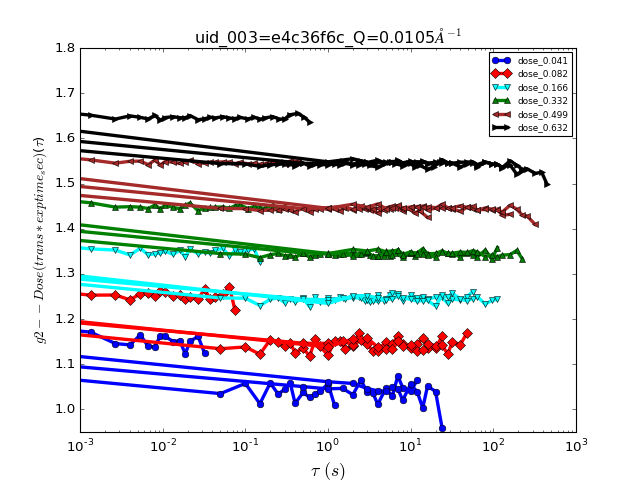

In [90]:
qth_interest = 0

plot_dose_g2( taus_uids, g2_uids, qth_interest= qth_interest, ylim=[0.95, 1.8], vshift= 0.1,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,
                 filename= 'oneq_dose_analysis',  legend_size = 8,
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

<IPython.core.display.Javascript object>


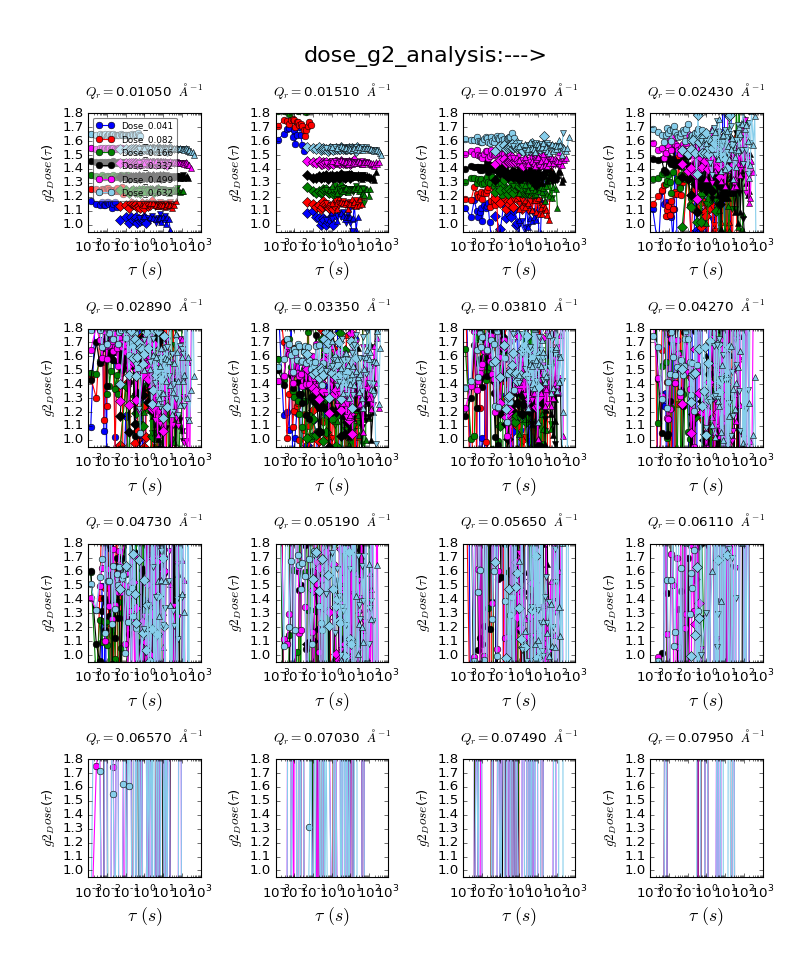

In [91]:
plot_dose_g2( taus_uids, g2_uids, ylim=[0.95, 1.2], vshift= 0.1,
                 qval_dict = qval_dict, fit_res= None,  geometry= scat_geometry,filename= filename, 
                path= data_dir, function= None,  ylabel='g2_Dose', g2_labels= None, append_name=  '' )

### Attach each g2 result to the corresponding olog entry

In [92]:
if att_pdf_report:     
    os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
    os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'
    pname =  data_dir  +  filename  + '.png'
    atch=[  Attachment(open(pname, 'rb')) ] 
    try:
        update_olog_uid( uid= fuids[-1], text='Add a dose dependent XPCS Analysis png file', attachments= atch )
    except:
        print("I can't attach this PDF: %s due to a duplicated filename. Please give a different PDF file."%pname)

The url=https://logbook.nsls2.bnl.gov/Olog-11-ID/Olog was successfully updated with Add a dose dependent XPCS Analysis png file and with the attachments


In [93]:
fuids[-1]

'e4c36f6c-c443-46d7-b264-7b06897de907'

# The End!